In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from tqdm import tqdm
import re
from collections import Counter
import seaborn as sns
import plotly.express as px
import typing
from sklearn.preprocessing import StandardScaler
import copy

## Load the datasets and merge them

In [91]:
df_features = pd.read_csv('../data/spotify_features.csv', delimiter='\t', names=['danceability', 'energy', 'key', 'loudness',
                                                     'mode', 'speechiness', 'acousticness',
                                                     'instrumentalness', 'liveness', 'valence',
                                                     'tempo', 'duration_ms', 'genres', 'popularity'])
df_songs = pd.read_csv('../data/songs_frame.csv', index_col=0)

In [92]:
nrows = 212886
df_features.reset_index(drop=True, inplace=True)
df_songs.reset_index(drop=True, inplace=True)
df_features = pd.concat([df_songs.iloc[0:len(df_features)], df_features], axis=1)
df_time_series = pd.read_csv('../data/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv', 
                             sep='\t', nrows=nrows, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
df_time_series = df_time_series.drop(columns=['artist-id', 'song-id'])

In [97]:
df_time_series

,user,timestamp,artist + song,artist,song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity
0,user_000001,2009-05-04T23:08:57Z,Deep Dish/Fuck Me Im Famous (Pacha Ibiza)-09-2...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,user_000001,2009-05-04T13:54:10Z,坂本龍一/Composition 0919 (Live_2009_4_15),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,user_000001,2009-05-04T13:52:04Z,坂本龍一/Mc2 (Live_2009_4_15),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,user_000001,2009-05-04T13:42:52Z,坂本龍一/Hibari (Live_2009_4_15),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,user_000001,2009-05-04T13:42:11Z,坂本龍一/Mc1 (Live_2009_4_15),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212881,user_000010,2007-03-11T13:31:51Z,Rihanna/Unfaithful,Rihanna,Unfaithful,0.588,0.391,0.0,-8.607,0.0,0.0334,0.839,0.0,0.227,0.349,144.069,226973.0,"['post-teen pop', 'pop', 'barbadian pop', 'urb...",92.0
212882,user_000010,2007-03-11T13:28:11Z,Dj Jurgen Present Alice Deeja/Better Off Alone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212883,user_000010,2007-03-11T13:25:00Z,After Sunrise Festival (Video Vocal Mix)/Dj Kris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212884,user_000010,2007-03-11T13:21:50Z,John Marks/Update,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
df_features = df_features[['artist','song', 'valence']]

In [77]:
df_features

,artist,song,valence
0,Minus 8,Elysian Fields,0.956
1,Beanfield,Planetary Deadlock,0.466
2,Alif Tree,Deadly Species,0.335
3,Minus 8,Cold Fusion,0.302
4,Marsmobil,Sovatex 2055,NaN
...,...,...,...
75160,Dj Krush,Beyond Raging Waves (Feat. Shin'Ichi Kinoshita),0.250
75161,Dj Vadim,My Favourite Letter,0.376
75162,Hird,Water Under My Bridges,0.461
75163,Weezer,Paperface,0.136


In [94]:
df_time_series['artist + song'] = df_time_series['artist'] + '/' + df_time_series['song']
df_features['artist + song'] = df_features['artist'] + '/' + df_features['song']
df_time_series = df_time_series.drop(columns=['artist', 'song']).merge(df_features, on='artist + song', how='left')

In [98]:
df_time_series = df_time_series.dropna(subset=['valence'])

In [99]:
df_time_series

,user,timestamp,artist + song,artist,song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity
17,user_000001,2009-05-03T15:10:18Z,Minus 8/Elysian Fields,Minus 8,Elysian Fields,0.627,0.871,9.0,-8.742,0.0,0.0328,0.0962,0.358000,0.109,0.956,89.102,272707.0,"['electro jazz', 'nu jazz']",42.0
18,user_000001,2009-05-03T15:04:31Z,Beanfield/Planetary Deadlock,Beanfield,Planetary Deadlock,0.775,0.624,7.0,-9.454,1.0,0.0475,0.1370,0.849000,0.101,0.466,89.997,345667.0,"['nu jazz', 'trip hop']",30.0
20,user_000001,2009-05-03T14:50:51Z,Alif Tree/Deadly Species,Alif Tree,Deadly Species,0.583,0.428,9.0,-12.336,0.0,0.0271,0.7780,0.687000,0.172,0.335,140.041,332040.0,"['nu jazz', 'trip hop']",30.0
21,user_000001,2009-05-03T14:46:29Z,Minus 8/Cold Fusion,Minus 8,Cold Fusion,0.348,0.599,6.0,-7.233,0.0,0.0323,0.1020,0.365000,0.197,0.302,171.985,260667.0,"['electro jazz', 'nu jazz']",42.0
37,user_000001,2009-05-02T15:29:50Z,4Hero/The Awakening,4Hero,The Awakening,0.453,0.635,6.0,-9.744,1.0,0.1040,0.5110,0.000000,0.620,0.667,95.701,285280.0,"['rave', 'broken beat', 'jungle', 'ninja', 'dr...",44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212813,user_000010,2007-03-12T14:25:00Z,System Of A Down/Lonely Day,System Of A Down,Lonely Day,0.470,0.796,8.0,-3.277,0.0,0.0336,0.3620,0.000001,0.133,0.215,113.108,167907.0,"['nu metal', 'rap metal', 'alternative metal']",81.0
212816,user_000010,2007-03-12T14:08:36Z,Outwork/Elektro (The Cube Guys Delano Remix),Outwork,Elektro (The Cube Guys Delano Remix),0.845,0.692,1.0,-9.135,1.0,0.0855,0.0085,0.223000,0.122,0.582,127.002,231024.0,"['circuit', 'funky tech house', 'disco house',...",51.0
212817,user_000010,2007-03-12T14:06:06Z,Basshunter/Boten Anna,Basshunter,Boten Anna,0.464,0.971,9.0,-5.546,0.0,0.2600,0.0635,0.000108,0.073,0.265,140.179,207067.0,"['europop', 'bubblegum dance', 'dance pop', 'e...",65.0
212836,user_000010,2007-03-11T16:27:36Z,G-Spott/Sadness,G-Spott,Sadness,0.716,0.584,11.0,-11.318,0.0,0.1090,0.0146,0.000045,0.150,0.541,134.934,174800.0,['dutch trance'],34.0


## Explore the songs

In [100]:
print(f"We have not found {df_features['valence'].isna().sum()} out of {len(df_features)} features")

We have not found 5489 out of 75165 features


In [101]:
df_features = df_features.dropna(subset=['valence'])

In [102]:
df_features

,artist,song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,artist + song
0,Minus 8,Elysian Fields,0.627,0.871,9.0,-8.742,0.0,0.0328,0.09620,0.35800,0.109,0.956,89.102,272707.0,"['electro jazz', 'nu jazz']",42.0,Minus 8/Elysian Fields
1,Beanfield,Planetary Deadlock,0.775,0.624,7.0,-9.454,1.0,0.0475,0.13700,0.84900,0.101,0.466,89.997,345667.0,"['nu jazz', 'trip hop']",30.0,Beanfield/Planetary Deadlock
2,Alif Tree,Deadly Species,0.583,0.428,9.0,-12.336,0.0,0.0271,0.77800,0.68700,0.172,0.335,140.041,332040.0,"['nu jazz', 'trip hop']",30.0,Alif Tree/Deadly Species
3,Minus 8,Cold Fusion,0.348,0.599,6.0,-7.233,0.0,0.0323,0.10200,0.36500,0.197,0.302,171.985,260667.0,"['electro jazz', 'nu jazz']",42.0,Minus 8/Cold Fusion
5,4Hero,The Awakening,0.453,0.635,6.0,-9.744,1.0,0.1040,0.51100,0.00000,0.620,0.667,95.701,285280.0,"['rave', 'broken beat', 'jungle', 'ninja', 'dr...",44.0,4Hero/The Awakening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75160,Dj Krush,Beyond Raging Waves (Feat. Shin'Ichi Kinoshita),0.767,0.786,1.0,-6.790,1.0,0.0650,0.01230,0.94600,0.075,0.250,140.503,263240.0,"['japanese old school hip hop', 'turntablism',...",45.0,Dj Krush/Beyond Raging Waves (Feat. Shin'Ichi ...
75161,Dj Vadim,My Favourite Letter,0.709,0.245,0.0,-12.515,1.0,0.4430,0.79100,0.00658,0.145,0.376,156.073,71053.0,"['turntablism', 'ninja', 'electronica', 'nu ja...",46.0,Dj Vadim/My Favourite Letter
75162,Hird,Water Under My Bridges,0.618,0.805,5.0,-10.081,0.0,0.0394,0.20600,0.80600,0.456,0.461,111.994,368947.0,"['electro jazz', 'nu jazz', 'trip hop']",38.0,Hird/Water Under My Bridges
75163,Weezer,Paperface,0.307,0.329,8.0,-13.140,1.0,0.0429,0.92400,0.89500,0.117,0.136,80.072,189190.0,['piano cover'],41.0,Weezer/Paperface


<AxesSubplot:xlabel='liveness', ylabel='Count'>

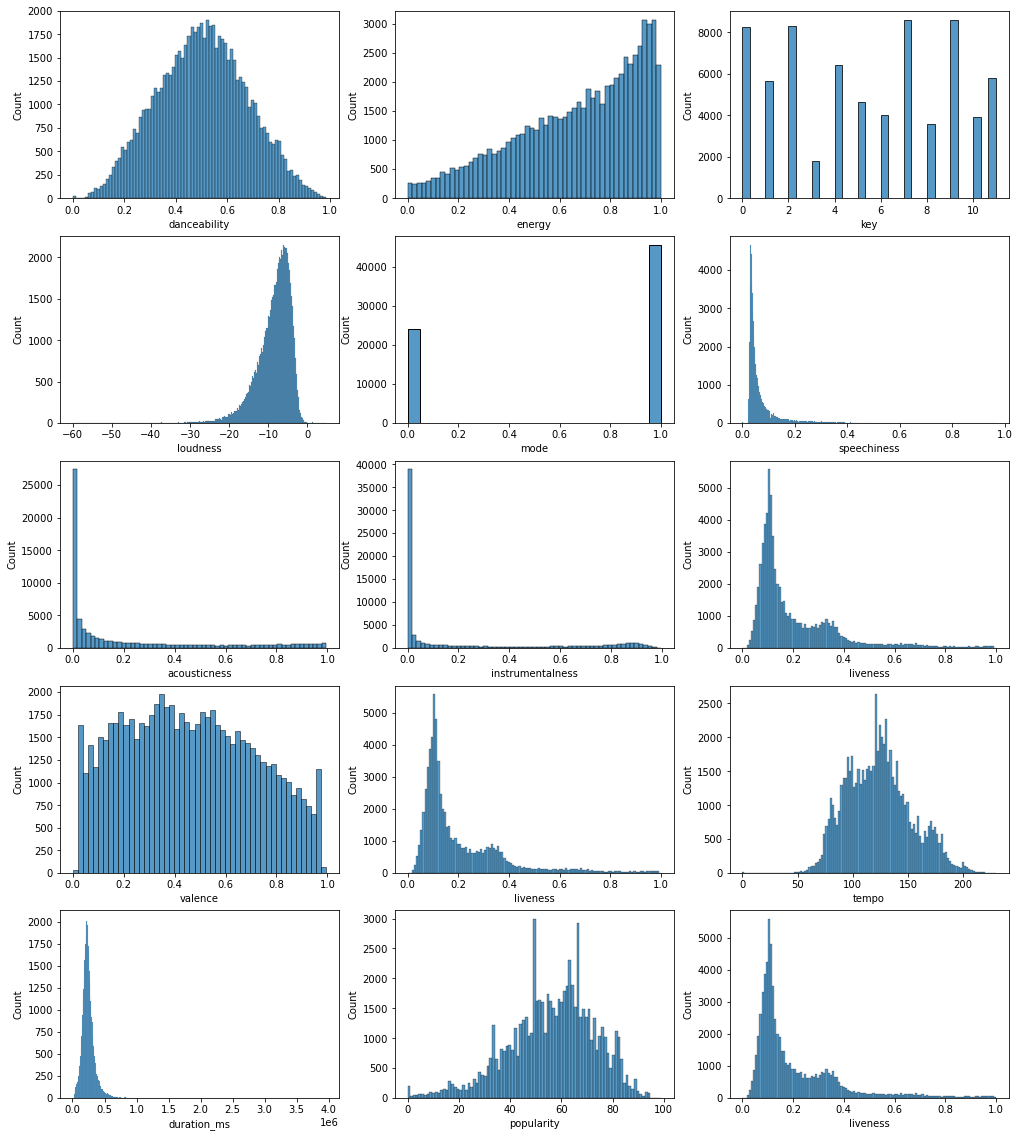

In [103]:
fig, axes = plt.subplots(5,3, figsize=(17,20))
sns.histplot(data=df_features, x='danceability', ax=axes[0,0])
sns.histplot(data=df_features, x='energy', ax=axes[0,1])
sns.histplot(data=df_features, x='key', ax=axes[0,2])
sns.histplot(data=df_features, x='loudness', ax=axes[1,0])
sns.histplot(data=df_features, x='mode', ax=axes[1,1])
sns.histplot(data=df_features, x='speechiness', ax=axes[1,2])
sns.histplot(data=df_features, x='acousticness', ax=axes[2,0])
sns.histplot(data=df_features, x='instrumentalness', ax=axes[2,1])
sns.histplot(data=df_features, x='liveness', ax=axes[2,2])
sns.histplot(data=df_features, x='valence', ax=axes[3,0])
sns.histplot(data=df_features, x='liveness', ax=axes[3,1])
sns.histplot(data=df_features, x='tempo', ax=axes[3,2])
sns.histplot(data=df_features, x='duration_ms', ax=axes[4,0])
sns.histplot(data=df_features, x='popularity', ax=axes[4,1])
sns.histplot(data=df_features, x='liveness', ax=axes[4,2])

#### Definition of the different metrics
(Given by [Towards Data Science](https://towardsdatascience.com/what-makes-a-song-likeable-dbfdb7abe404))
- **Danceability:** Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.
- **Valence:** Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- **Energy:** Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.
- **Tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece, and derives directly from the average beat duration.
- **Loudness:** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.
- **Speechiness:** This detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
- **Instrumentalness:** Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”.
- **Liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- **Acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic.
- **Key:** The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.
- **Mode:** Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- **Duration:** The duration of the track in milliseconds.

## Time series exploration

In [104]:
for user in df_time_series['user'].unique():
    print(f"{user} has {len(df_time_series[df_time_series['user'] == user])} entries")

user_000001 has 5384 entries
user_000002 has 43721 entries
user_000003 has 13523 entries
user_000004 has 11624 entries
user_000005 has 10682 entries
user_000006 has 8568 entries
user_000007 has 435 entries
user_000008 has 34261 entries
user_000009 has 3580 entries
user_000010 has 2473 entries


In [108]:
df_time_series.loc[:,'timestamp'] = pd.to_datetime(df_time_series['timestamp'])

In [114]:
df_time_series.loc[:,'valence_norm'] = df_time_series.groupby('user')['valence'].transform(lambda x: (x - x.mean()) / x.std())
df_time_series.loc[:,'valence_max_min'] = df_time_series.groupby('user')['valence'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

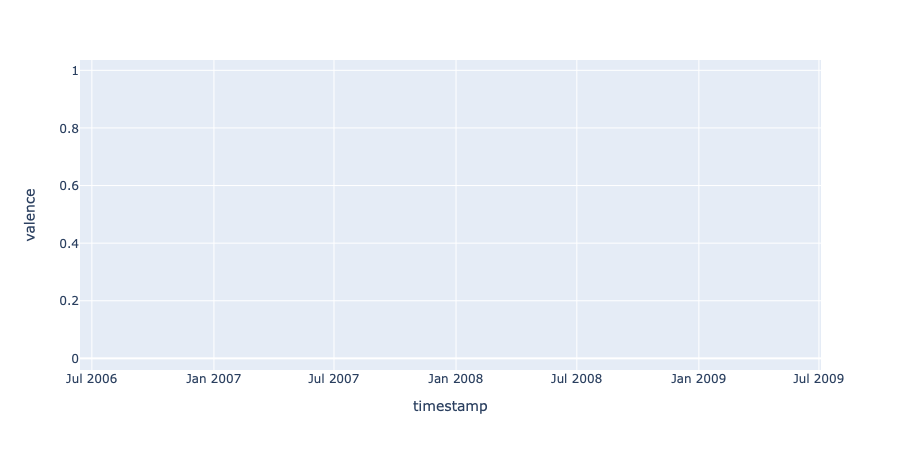

In [116]:
fig = px.scatter(df_time_series[df_time_series['user']=='user_000001'], x='timestamp', y='valence', hover_data=['artist', 'song'])
fig.show()

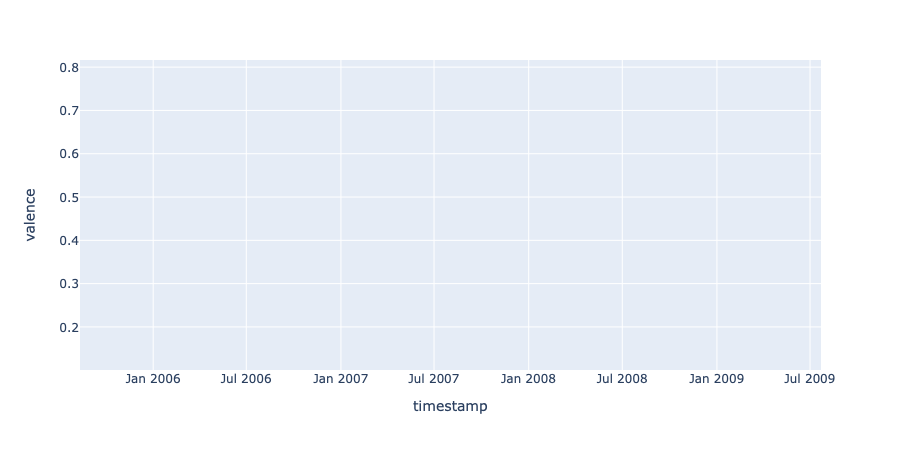

In [117]:
df_day = df_time_series.groupby(by=[df_time_series['timestamp'].dt.date]).mean().reset_index()
fig = px.scatter(df_day, x='timestamp', y='valence')
fig.show()

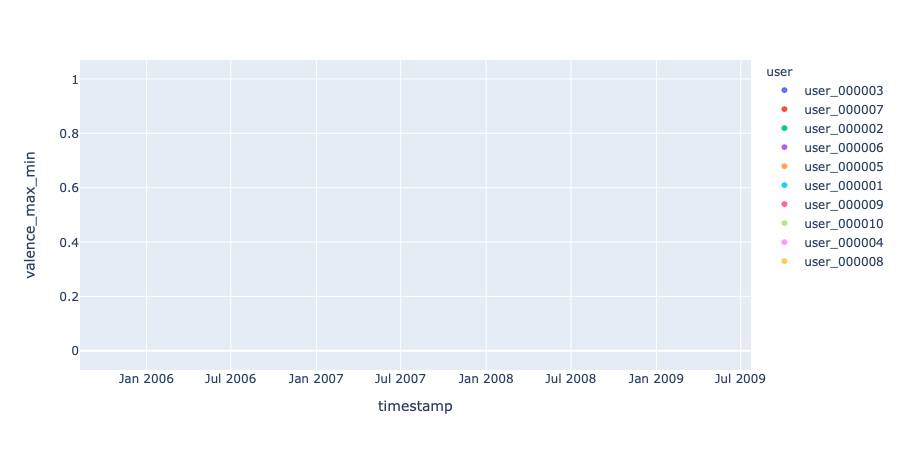

In [120]:
df_day = df_time_series.groupby(by=[df_time_series['timestamp'].dt.date, 'user']).mean().reset_index()
fig = px.scatter(df_day, x='timestamp', y='valence_max_min', color='user')
fig.show()

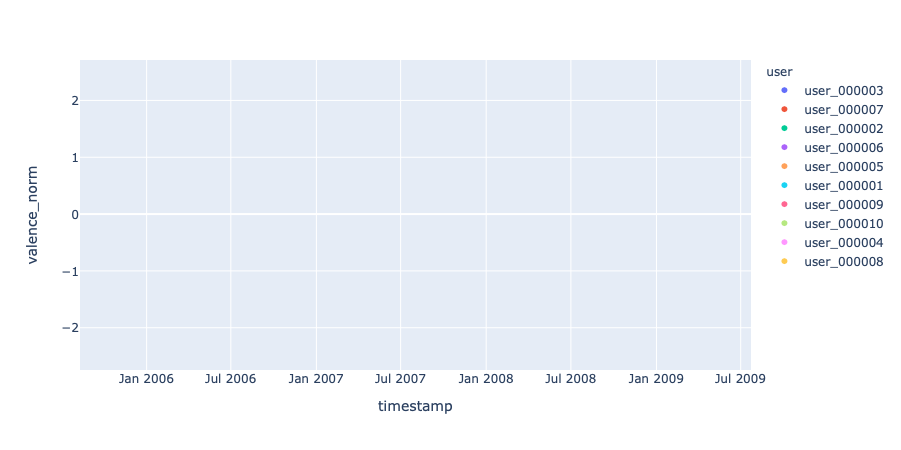

In [122]:
df_day = df_time_series.groupby(by=[df_time_series['timestamp'].dt.date, 'user']).mean().reset_index()
fig = px.scatter(df_day, x='timestamp', y='valence_norm', color='user')
fig.show()

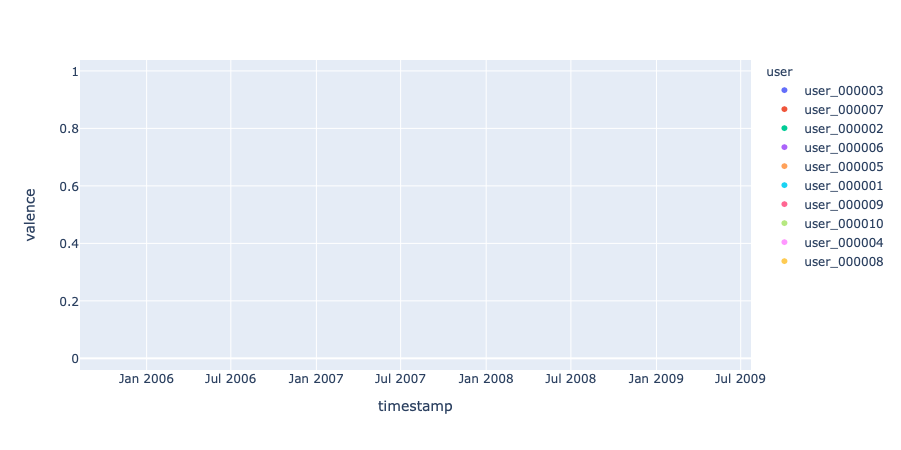

In [123]:
df_day = df_time_series.groupby(by=[df_time_series['timestamp'].dt.date, 'user']).mean().reset_index()
fig = px.scatter(df_day, x='timestamp', y='valence', color='user')
fig.show()

In [124]:
df_day['valence']

0       0.577437
1       0.528004
2       0.531271
3       0.327606
4       0.585667
          ...   
4198    0.514750
4199    0.425000
4200    0.277000
4201    0.418500
4202    0.442000
Name: valence, Length: 4203, dtype: float64

In [125]:
df_day = df_time_series.groupby(by=['user', df_time_series['timestamp'].dt.date]).mean().reset_index()

In [126]:
df_time_series.groupby(by=['user', df_time_series['timestamp'].dt.date]).mean()

danceability    energy        key   loudness  \
user        timestamp                                                  
user_000001 2006-08-13      0.438633  0.522177   6.033333 -15.366533   
            2006-08-15      0.692143  0.702429   2.857143  -8.662143   
            2006-08-16      0.595500  0.884000   4.500000  -8.673500   
            2006-08-21      0.575750  0.462750   4.750000 -12.108125   
            2006-08-23      0.592000  0.648000   4.750000  -7.074500   
...                              ...       ...        ...        ...   
user_000010 2009-04-26      0.599737  0.869632   7.157895  -4.935263   
            2009-04-28      0.582588  0.879235   6.941176  -4.949882   
            2009-04-29      0.713000  0.960000  11.000000  -2.340000   
            2009-04-30      0.599737  0.869632   7.157895  -4.935263   
            2009-05-04      0.501000  0.889000   4.000000  -3.890000   

                            mode  speechiness  acousticness  instrumentalness  \
user        timestamp                                                           
user_000001 2006-08-13  0.566667     0.068110      0.416596          0.704946   
            2006-08-15  0.714286     0.097243      0.031008          0.353943   
            2006-08-16  0.500000     0.117900      0.038085          0.835000   
            2006-08-21  0.500000     0.048650      0.436278          0.176017   
            2006-08-23  0.625000     0.049025      0.002943          0.807750   
...                          ...          ...           ...               ...   
user_000010 2009-04-26  0.631579     0.103068      0.011561          0.336759   
            2009-04-28  0.647059     0.101353      0.010117          0.376299   
            2009-04-29  1.000000     0.143000      0.038100          0.000013   
            2009-04-30  0.631579     0.103068      0.011561          0.336759   
            2009-05-04  0.000000     0.029600      0.000323          0.001640   

                        liveness   valence       tempo    duration_ms  \
user        timestamp                                                   
user_000001 2006-08-13  0.162030  0.251140  121.478767  250175.466667   
            2006-08-15  0.246257  0.441043  128.531571  322592.428571   
            2006-08-16  0.101050  0.531000  171.546500  318173.000000   
            2006-08-21  0.135387  0.531750  113.741125  292016.000000   
            2006-08-23  0.137500  0.474250  110.613625  267160.000000   
...                          ...       ...         ...            ...   
user_000010 2009-04-26  0.274663  0.429837  126.501158  252130.315789   
            2009-04-28  0.284741  0.411876  128.921824  256608.411765   
            2009-04-29  0.255000  0.714000  101.982000  209760.000000   
            2009-04-30  0.274663  0.429837  126.501158  252130.315789   
            2009-05-04  0.186000  0.442000   94.370000  205107.000000   

                        popularity  valence_norm  valence_max_min  
user        timestamp                                              
user_000001 2006-08-13   60.766667     -0.691784         0.238426  
            2006-08-15   45.428571      0.038203         0.439893  
            2006-08-16   69.500000      0.383998         0.535328  
            2006-08-21   42.250000      0.386881         0.536123  
            2006-08-23   49.000000      0.165851         0.475122  
...                            ...           ...              ...  
user_000010 2009-04-26   69.368421     -0.380399         0.423564  
            2009-04-28   70.117647     -0.466370         0.404219  
            2009-04-29   63.000000      0.979807         0.729642  
            2009-04-30   69.368421     -0.380399         0.423564  
            2009-05-04   86.000000     -0.322177         0.436665  

[4203 rows x 15 columns]

## Final comment
We have conducted many different analysis steps by using the power of the interactive plotly ploting interface. With more data, we could identify some kind of pattern in the `valence` feature. We could not find conclusive patterns and need to try different techniques to find behavioural features of the different user and the music they listen to. It seems also that many users listen to a certain album for a long time. This makes the time series analysis even more complicated because an album contains differnent songs with different moods. The user might have a listening behaviour of just listening to the album without reflecting his emotional state in his song choice. We need to conduct further analysis:
- Cluster different listening patterns: People who listen to random song or playlist, whole albums or artist. 
- Find patterns in the song choice in order to give better recommendations.
- We might need to use spark or a similar framework as the data gets quite heavy.